In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import feather

In [2]:
df_train = pd.read_csv('MNIST_CSV/mnist_train.csv', header=None)
df_test = pd.read_csv('MNIST_CSV/mnist_test.csv', header=None)

y_train = df_train[0].to_numpy()
y_test = df_test[0].to_numpy()
x_train = df_train.iloc[:, 1:785].to_numpy()
x_test = df_test.iloc[:, 1:785].to_numpy()

x_train_img = np.reshape(x_train, (60000, 28, 28))
x_test_img = np.reshape(x_test, (10000, 28, 28))

<h3><b>Generating 9 new combinations of training images by random rotation and pixel shift</b></h3>

In [59]:
#function to shift image along diagonal
def shift_diagonal(dir, x):
    temp = np.copy(x)
    shift = np.random.randint(low=2, high=4, size=1)[0]

    if dir == 'main_diag_right':
        for i in range(shift, 28):
            for j in range(shift, 28):
                temp[i][j] = x[i - shift][j - shift]

        temp[:, :shift] = np.zeros((28, shift))
        temp[:shift, :] = np.zeros((shift, 28))
    
    elif dir == 'main_diag_left':
        for i in range(28 - shift):
            for j in range(28 - shift):
                temp[i][j] = x[i + shift][j + shift]

        temp[:, -shift:] = np.zeros((28, shift))
        temp[-shift:, :] = np.zeros((shift, 28))

    elif dir == 'anti_diag_right':
        for i in range(28 - shift):
            for j in range(shift, 28):
                temp[i][j] = x[i + shift][j - shift]
        
        temp[:, :shift] = np.zeros((28, shift))
        temp[-shift:, :] = np.zeros((shift, 28))

    elif dir == 'anti_diag_left':
        for i in range(shift, 28):
            for j in range(28 - shift):
                temp[i][j] = x[i - shift][j + shift]
        
        temp[:, -shift:] = np.zeros((28, shift))
        temp[:shift, :] = np.zeros((shift, 28))
        
    return temp

In [296]:
#image augmentation function to produce more training data
def augment_image(dir, x):
    #performing random rotation
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.RandomRotation(degrees=15)])
    
    transformed_arr = np.empty(x.shape)

    for i in range(x.shape[0]):
        transformed_arr[i] = transform(x[i]).numpy().reshape(28, 28)
        shift = np.random.randint(low=2, high=4, size=1)[0]
        
        if dir == 'none':
            pass

        elif dir == 'right':
            transformed_arr[i] = np.roll(transformed_arr[i], shift, axis=1)
            transformed_arr[i, :, :shift] = np.zeros((28, shift))
        
        elif dir == 'left':
            transformed_arr[i] = np.roll(transformed_arr[i], -shift, axis=1)
            transformed_arr[i, :, -shift:] = np.zeros((28, shift))

        elif dir == 'up':
            transformed_arr[i] = np.roll(transformed_arr[i], -shift, axis=0)
            transformed_arr[i, -shift:, :] = np.zeros((shift, 28))

        elif dir == 'down':
            transformed_arr[i] = np.roll(transformed_arr[i], shift, axis=0)
            transformed_arr[i, :shift, :] = np.zeros((shift, 28))

        else:
            transformed_arr[i] = shift_diagonal(dir, transformed_arr[i])
    
    return transformed_arr

In [297]:
df_augmented = df_train
col_names = [i for i in range(1, 785)]
options = ['right',
           'left',
           'up',
           'down',
           'main_diag_left',
           'main_diag_right',
           'anti_diag_left',
           'anti_diag_right',
           'none']

for option in options:
    augmented_img = augment_image(option, x_train_img)
    augmented_img = augmented_img.astype(np.int64)
    new_df = pd.concat([pd.Series(y_train),
                        pd.DataFrame(augmented_img.reshape(-1, 784),
                                     columns=col_names)], axis=1)
    
    df_augmented = pd.concat([df_augmented, new_df], axis=0, ignore_index=True)


In [298]:
#new augmented dataset
df_augmented

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
599996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
599997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
599998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h3><b>Storing dataframe as .feather file since space occupied is lesser</b></h3>

In [323]:
df_augmented = df_augmented.astype(np.uint8)
df_augmented.rename(columns={col: str(col) for col in df_augmented.columns}, inplace=True)
df_augmented.to_feather('augmented_MNIST.feather')

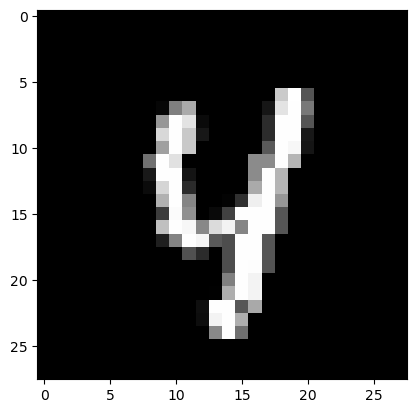

In [326]:
new_img = augment_image('none', x_train_img[1006].reshape(1, 28, 28))

plt.imshow(new_img[0], cmap='gray')
plt.show()